In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

In [4]:
import tensorflow, keras
tensorflow.__version__

'2.11.0'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/fraud_detection_dataset/creditcardd.parquet')

In [ ]:
df.shape

(284807, 31)

In [ ]:
print("Total time spanning: {:.1f} days".format(df['Time'].max() / (3600 * 24.0)))
print("{:.3f} % of all transactions are fraud. ".format(np.sum(df['Class']) / df.shape[0] * 100))


Total time spanning: 2.0 days
0.173 % of all transactions are fraud. 


In [ ]:
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

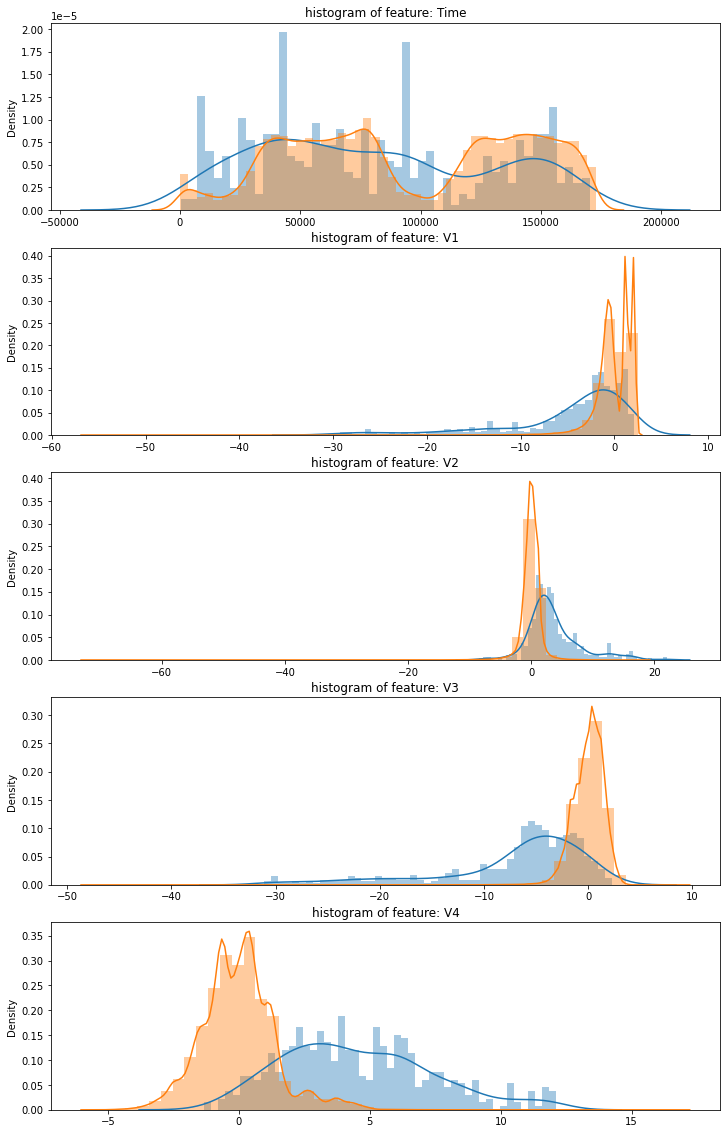

In [ ]:
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=0)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227454, 30)

In [ ]:
# print("Total train examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(X1_train.shape[0], np.sum(Y1_train), np.sum(Y1_train)/X1_train.shape[0]))
# print("Total test examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(X1_test.shape[0], np.sum(y1_test), np.sum(y1_test)/y1_test.shape[0]))


Total train examples: 256326, total fraud cases: 437, equal to 0.00170 of total cases. 
Total test examples: 28481, total fraud cases: 55, equal to 0.00193 of total cases. 


In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 23s 3ms/step - loss: 375076192.0000 - accuracy: 3.5612e-04 - val_loss: 373988928.0000 - val_accuracy: 3.3356e-04
Epoch 2/100
7108/7108 [==============================] - 19s 3ms/step - loss: 374735712.0000 - accuracy: 0.4958 - val_loss: 373630336.0000 - val_accuracy: 0.9997
Epoch 3/100
7108/7108 [==============================] - 18s 3ms/step - loss: 374378496.0000 - accuracy: 0.9996 - val_loss: 373272960.0000 - val_accuracy: 0.9997
Epoch 4/100
7108/7108 [==============================] - 24s 3ms/step - loss: 374020032.0000 - accuracy: 0.9996 - val_loss: 372915552.0000 - val_accuracy: 0.9997
Epoch 5/100
7108/7108 [==============================] - 18s 3ms/step - loss: 373663616.0000 - accuracy: 0.9996 - val_loss: 372559456.0000 - val_accuracy: 0.9997
Epoch 6/100
7108/7108 [==============================] - 21s 3ms/step - loss: 373305408.0000 - accuracy: 0.9996 - val_loss: 372202592.0000 - val_accuracy: 0.9997
Epoch 7/100
7108/710

In [ ]:
from keras.models import Model, load_model
autoencoder = load_model('model.h5')


In [ ]:
data = {'Time':432.653444627294995,'V1': -0.45678, 'V2': 3.160225076852038, 'V3': 11.59225555524082, 'V4': 14.29683228357565, 'V5': 0.997174923623236, 'V6': -0.343000302409134, 'V7': 0.469936930779834, 'V8': -0.132470081994361, 'V9': -0.197794077439788, 'V10': -0.105005538081425, 'V11': -0.543662210926971, 'V12': 0.302233022635964, 'V13': 0.141211078726449, 'V14': -0.207880443553101, 'V15': 0.0241083998795536, 'V16': -1.20687659191564, 'V17': 0.39483638189259, 'V18': -0.750955630206426, 'V19': 0.440558481170408, 'V20': 0.225920346918541, 'V21': 0.0383629679790368, 'V22': 0.336449012374641, 'V23': -0.0148828328356718, 'V24': 0.3223232, 'V25': -0.265322060067868, 'V26': -0.34863668662622, 'V27': 0.0112384491290326, 'V28': -0.0494783399721492, 'Amount': 19.85}

input_data = np.array(list(data.values()))
input_data = np.reshape(input_data, (1, 30))
# input_data.shape

In [ ]:

prediction = autoencoder.predict(input_data)
# mse = np.mean(np.power(X1_test - predictions, 2), axis=1)
# df_error = pd.DataFrame({'reconstruction_error': mse,
#                         'true_class': y1_test})
# df_error.describe()

prediction = prediction / 100
prediction[0][0]

1/1 [==============================] - 0s 30ms/step


56.371635

#Feature Normalization 2 - z score (for tanh activation)


array([[-1.35980713, -0.07278117,  2.53634674, ..., -0.18911484,
         0.13355838, -0.02105305],
       [ 1.19185711,  0.26615071,  0.16648011, ...,  0.12589453,
        -0.0089831 ,  0.01472417],
       [-1.35835406, -1.34016307,  1.77320934, ..., -0.13909657,
        -0.05535279, -0.05975184],
       ...,
       [-0.26141928,  0.70068377, -1.23644754, ...,  0.1521317 ,
         0.12513927,  0.18596741],
       [ 2.11313331,  0.16076067, -1.92636224, ...,  0.20459758,
        -0.0618713 , -0.03541829],
       [-0.95970656, -0.26547772,  0.98265371, ..., -0.18266003,
        -0.01383669, -0.00358891]])

In [ ]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

In [ ]:
# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 256
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
#n_hidden_2 = 15 # 2nd layer num features
n_input = train_x.shape[1] # MNIST data input (img shape: 28*28)
data_dir = '.'

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
X = tf.placeholder("float", [None, n_input])
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   #biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                  # biases['decoder_b2']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = train_x[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Train auc=", "{:.6f}".format(auc(train_y, train_batch_mse)), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch: 0001 cost= 0.942575037 Train auc= 0.954229 Time elapsed= 0:00:01.785963
Epoch: 0002 cost= 0.751770139 Train auc= 0.957034 Time elapsed= 0:00:02.989828
Epoch: 0003 cost= 0.847978711 Train auc= 0.957401 Time elapsed= 0:00:04.197964
Epoch: 0004 cost= 0.419228792 Train auc= 0.958278 Time elapsed= 0:00:05.351629
Epoch: 0005 cost= 0.349099904 Train auc= 0.957933 Time elapsed= 0:00:06.563348
Epoch: 0006 cost= 0.382366747 Train auc= 0.959458 Time elapsed= 0:00:07.772874
Epoch: 0007 cost= 0.401267856 Train auc= 0.960536 Time elapsed= 0:00:08.948727
Epoch: 0008 cost= 0.438832134 Train auc= 0.960715 Time elapsed= 0:00:10.480845
Epoch: 0009 cost= 0.334588975 Train auc= 0.958058 Time elapsed= 0:00:11.979578
Epoch: 0010 cost= 0.310320795 Train auc= 0.956451 Time elapsed= 0:00:13.411683
Optimization Finished!
Model saved in file: ./temp_saved_model_1layer.ckpt


In [ ]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})
    
    print("Test auc score: {:.6f}".format(auc(test_y, test_batch_mse)))

Test auc score: 0.946289


In [ ]:
t = {'Time': 67.0, 'V1': -0.653444627294995, 'V2': 0.160225076852038, 'V3': 1.59225555524082, 'V4': 1.29683228357565, 'V5': 0.997174923623236, 'V6': -0.343000302409134, 'V7': 0.469936930779834, 'V8': -0.132470081994361, 'V9': -0.197794077439788, 'V10': -0.105005538081425, 'V11': -0.543662210926971, 'V12': 0.302233022635964, 'V13': 0.141211078726449, 'V14': -0.207880443553101, 'V15': 0.0241083998795536, 'V16': -1.20687659191564, 'V17': 0.39483638189259, 'V18': -0.750955630206426, 'V19': 0.440558481170408, 'V20': 0.225920346918541, 'V21': 0.0383629679790368, 'V22': 0.336449012374641, 'V23': -0.0148828328356718, 'V24': 0.102959010243, 'V25': -0.265322060067868, 'V26': -0.34863668662622, 'V27': 0.0112384491290326, 'V28': -0.0494783399721492, 'Amount': 19.85}
t= np

(28,)

In [ ]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})
    